<a href="https://colab.research.google.com/github/MarciaFG/scimobility/blob/main/AlignP_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Academic Alignment PCA analysis**

Author: Marcia R. Ferreira (Complexity Science Hub Vienna & TU Wien)

Date: 

Input: Institutional level dataset

Output: PCA

Other notes: 

# Colab Initialization

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Wed Nov  9 13:10:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install required Drivers

In [3]:
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
import torch
import nltk
import io
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.style.use('ggplot')
%matplotlib inline
from google.cloud import bigquery
import humanize

# enable data table format
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [4]:
# load the data
from google.colab import drive
#drive.mount('/content/drive')

# run this to upload files
from google.colab import files
uploaded = files.upload()

# import it into a pandas dataframe
df = pd.read_csv(io.BytesIO(uploaded['dataset.csv']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving dataset.csv to dataset (6).csv


In [5]:
print(df.columns)
print(df.shape)

Index(['grid', 'label', 'organization_type', 'organization_type_id',
       'Quartile', 'pp_top_prop1', 'pp_top_prop5', 'pp_top_prop10', 'TNCS',
       'P', 'total_researchers', 'pp_newcomers', 'pp_outgoers',
       'pp_topics_newcomers', 'pp_topics_outgoers', 'pp_p_collab_new_native',
       'pp_p_collab_out_resident', 'pp_skills', 'net_gain_loss', 'costheta',
       'coseta', 'costheta_wo_collab', 'coseta_wo_collab', 'Log10TNCS',
       'Log10P', 'Log10total_researchers', 'Quartile_RECODED', 'LogPxr',
       'costhetaXpcollabnew', 'q_1', 'q_2', 'q_3', 'q_4', 'Q1', 'ptop1',
       'Log10ptop1', 'SkillsXlogr', 'idcase__'],
      dtype='object')
(3965, 38)


# **Preprocessing**
The next step will be defining the features, separating them out from the response variable and standardizing them as the input for PCA:

In [6]:
# subsetting the important features
df.drop(['LogPxr', 'costhetaXpcollabnew','q_1', 'q_2'\
         , 'q_3', 'q_4', 'Q1', 'Log10ptop1', 'SkillsXlogr'\
         , 'idcase__', 'net_gain_loss', 'Log10TNCS', 'Log10P'\
         , 'Log10total_researchers', 'Quartile_RECODED', 'ptop1']\
         , axis=1, inplace=True)

print(df.columns)
print(df.shape)

Index(['grid', 'label', 'organization_type', 'organization_type_id',
       'Quartile', 'pp_top_prop1', 'pp_top_prop5', 'pp_top_prop10', 'TNCS',
       'P', 'total_researchers', 'pp_newcomers', 'pp_outgoers',
       'pp_topics_newcomers', 'pp_topics_outgoers', 'pp_p_collab_new_native',
       'pp_p_collab_out_resident', 'pp_skills', 'costheta', 'coseta',
       'costheta_wo_collab', 'coseta_wo_collab'],
      dtype='object')
(3965, 22)


## Subsetting and Encoding the categorical predictors

In [7]:
# creating the features
# first for predicting costheta
# creating the target variable
costheta =  df['costheta']
# x feature vector creation
costheta_predictors = df[['pp_top_prop1','pp_top_prop5'
                          ,'pp_top_prop10','TNCS','P','total_researchers'
                          ,'pp_newcomers', 'pp_topics_newcomers' 
                          , 'pp_p_collab_new_native', 'pp_skills']]

X_costheta_predictors = np.array(costheta_predictors)
Y_costheta_response = np.array(costheta)

"""
# encoding categorical data
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(), [0])], \
                       remainder='passthrough')

X_costheta_predictors = np.array(ct.fit_transform(costheta_predictors))
"""

"\n# encoding categorical data\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.preprocessing import OneHotEncoder\n\nct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(), [0])],                        remainder='passthrough')\n\nX_costheta_predictors = np.array(ct.fit_transform(costheta_predictors))\n"

In [8]:
print(costheta_predictors)
print(X_costheta_predictors)
print(Y_costheta_response)
#X_costheta_predictors_df = pd.DataFrame(X_costheta_predictors)
#print(X_costheta_predictors_df)

      pp_top_prop1  pp_top_prop5  pp_top_prop10           TNCS      P  \
0            0.003         0.019          0.043     495.840000    793   
1            0.007         0.031          0.064    3852.670000   4738   
2            0.001         0.015          0.031     584.780000   1332   
3            0.007         0.033          0.073    3396.433698   3911   
4            0.004         0.027          0.064   11094.400000  13854   
...            ...           ...            ...            ...    ...   
3960         0.033         0.128          0.223  164461.000000  84570   
3961         0.022         0.094          0.173   89688.600000  57366   
3962         0.033         0.122          0.209   14673.800000   7790   
3963         0.026         0.101          0.179   29172.700000  18133   
3964         0.030         0.112          0.194   19255.000000  11206   

      total_researchers  pp_newcomers  pp_topics_newcomers  \
0                  1499          0.14                 0.37   

## Standardization of all features

In [9]:
# scale the data using StandardScaler
# StandardScaler will standardize the features by removing the mean and scaling
# to unit variance so that each feature has μ = 0 and σ = 1.
from sklearn.preprocessing import StandardScaler

# Standardization {-3,3 range}
# remember that dummy variables do not need to be standardized
# only applies to non-dummy values
# it only takes in arrays
ac = StandardScaler()
X_costheta_predictors = ac.fit_transform(X_costheta_predictors) 

Y_costheta_response = Y_costheta_response.reshape(1, -1)
Y_costheta_response = ac.fit_transform(Y_costheta_response)

print(X_costheta_predictors)
print(Y_costheta_response)

# **Principal Component Analysis - PCA**
- We use it as noise filtering and feature extraction
- We also use it as a robustness test to check which components explain most of the variance in our dataset
- If it agrees with the multivariate linear regression then we can use it as robustness test for the relationship between Alignment measures and the impact and specialization metrics

In PCA, we first need to know how many components are required to explain at least 90% of our feature variation

Shape before PCA:  (3965, 10)
Shape after PCA:  (3965, 4)


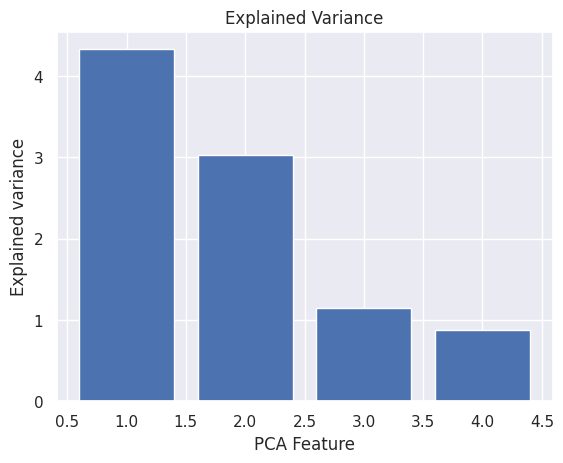

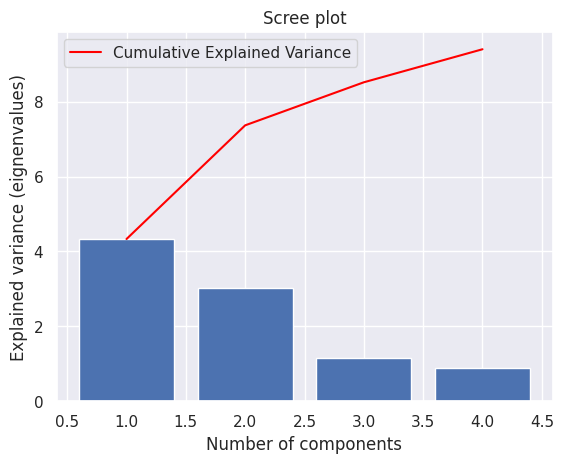

cumulative explained variance: [43.2984866  30.34307342 11.49009844  8.81858693]


In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca_fit = PCA(n_components=4).fit(X_costheta_predictors)  
X_costheta_predictors_pca = pca.fit_transform(X_costheta_predictors)
# here just add the other predictor features
print('Shape before PCA: ', X_costheta_predictors.shape)
print('Shape after PCA: ', X_costheta_predictors_pca.shape)

# Bar plot of explained_variance
import seaborn as sns 
sns.set()
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Explained Variance')
plt.show()

# Line plot of explained cummulative variance
# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
plt.plot(
    range(1,len(pca.explained_variance_ )+1),
    np.cumsum(pca.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

print('cumulative explained variance:', pca.explained_variance_ratio_*100)

We interpret the cumulative variances as follows:

    - The first component alone captures about 43% variability in the data
    - The second component alone captures about 30% variability in the data
    - The first two components capture about 73% variability in the data 
    - The third component alone captures about 11.5% variability in the data
    - The first three components together capture about 84.5% variability in the data
    - With the fourth component alone only capturing about 8% variability in the data 

**Let’s now apply PCA to find the desired number of components based on the desired explained variance, say 85%:**

Cumulative Variances (Percentage):
[43.2984866  73.64156002 85.13165847]
Number of components: 3


Text(0, 0.5, 'Explained variance (%)')

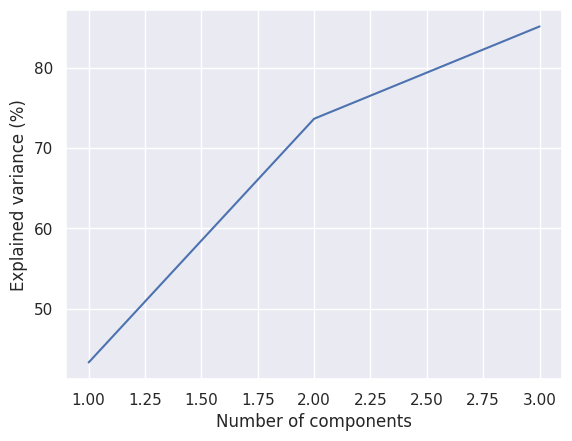

In [44]:
pca = PCA(n_components = 0.84)
pca.fit(X_costheta_predictors)
print("Cumulative Variances (Percentage):")
print(np.cumsum(pca.explained_variance_ratio_ * 100))
components = len(pca.explained_variance_ratio_)
print(f'Number of components: {components}')# Make the scree plot
plt.plot(range(1, components + 1), np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components")
plt.ylabel("Explained variance (%)")

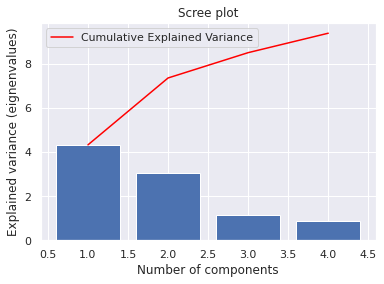

In [26]:
# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
plt.plot(
    range(1,len(pca.explained_variance_ )+1),
    np.cumsum(pca.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

In [12]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X_costheta_predictors)

In [28]:
pca.explained_variance_ratio_*100

array([0.43298487, 0.30343073, 0.11490098, 0.08818587])

## Principal component visualization

We only need two components. Three components were chose as the optimum number of components. Three explain at least 95% of variance in the dataset.

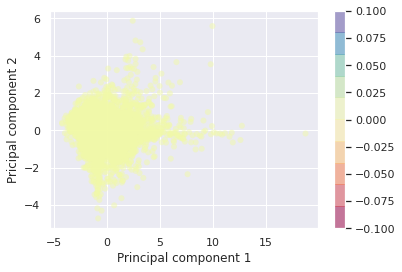

In [17]:
plt.scatter(principalComponents[:, 0], principalComponents[:, 3],
c=Y_costheta_response, edgecolor='none', alpha=0.5,
cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Principal component 1')
plt.ylabel('Pricipal component 2')
plt.colorbar()

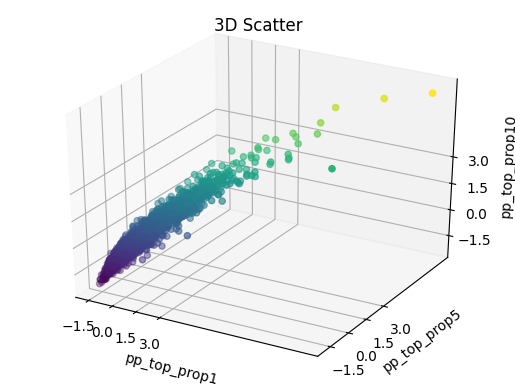

In [30]:
#Let’s see an example by plotting our selected features into a 3D graph.
from mpl_toolkits import mplot3d
plt.style.use('default')
 
# Prepare 3D graph
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot scaled features
xdata = X_costheta_predictors[:,0]
ydata = X_costheta_predictors[:,1]
zdata = X_costheta_predictors[:,2]

# Plot 3D plot
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='viridis')

# Plot title of graph
plt.title(f'3D Scatter')

# Plot x, y, z even ticks
ticks = np.linspace(-3, 3, num=5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_zticks(ticks)

# Plot x, y, z labels
ax.set_xlabel('pp_top_prop1', rotation=150)
ax.set_ylabel('pp_top_prop5')
ax.set_zlabel('pp_top_prop10', rotation=60)
plt.show()

Plot the 2D PCA graph

In [ ]:
# Create dataframe
pca_df = pd.DataFrame(
    data=principalComponents, 
    columns=['PC1', 'PC2', 'PC3', 'PC4'])

# map cosine values to PCA features
pca_df['target'] = Y_costheta_response
pca_df['target']